<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>


<a id='top'></a>

# Contents

[scrape data](#scrape)

[create descriptors](#descriptors)

[optimize LASSO](#optimize)

[create confidence intervals for coefficients](#ci_coeff)

[multi-layer perceptron (MLP) regressor](#nn)

[create static files](#static)

In [1]:
import statistics
import requests
import json
import pickle
import salty
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from scipy import stats
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from math import log
from time import sleep
%matplotlib inline
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

class dev_model():
    def __init__(self, coef_data, data):
        self.Coef_data = coef_data
        self.Data = data
        
class prod_model():
    def __init__(self, coef_data, model):
        self.Coef_data = coef_data
        self.Model = model

<a id='scrape'></a>

# Scrape ILThermo Data

[back to top](#top)

ILThermo has specific 4-letter tags for the properties in the database. These can be determined by inspecting the web elements on their website.

Melting point: prp=lcRG (note this in the paper_url string)

All that needs to be changed to scrape other property data is the 4-letter tag and the directory in which to save the information.

In [2]:
paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?"\
    "cmp=&ncmp=1&year=&auth=&keyw=&prp=lcRG"
    
r = requests.get(paper_url)
header = r.json()['header']
papers = r.json()['res']
i = 1
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
for paper in papers[:1]:
    
    r = requests.get(data_url.format(paper_id=paper[0]))
    data = r.json()['data']
    with open("../salty/data/MELTING_POINT/%s.json" % i, "w") as outfile:
        json.dump(r.json(), outfile)
    #then do whatever you want to data like writing to a file
    sleep(0.5) #import step to avoid getting banned by server
    i += 1

<a id='descriptors'></a>

# Create Descriptors

[back to top](#top)

The scraped data is in the form of a json file. The json files contain all the experimental information NIST has archived, including methods and experimental error!

Unfortunately the IUPAC names in the database are imperfect. We address this after the following cell.

In [ ]:
###add JSON files to density.csv
outer_old = pd.DataFrame()
outer_new = pd.DataFrame()
number_of_files = 2266

for i in range(10):
    with open("../salty/data/DENSITY/%s.json" % str(i+1)) as json_file:
        
        #grab data, data headers (names), the salt name
        json_full = json.load(json_file)
        json_data = pd.DataFrame(json_full['data'])
        json_datanames = np.array(json_full['dhead'])
        json_data.columns =  json_datanames
        json_saltname = pd.DataFrame(json_full['components'])
        print(json_saltname.iloc[0][3])
        
        inner_old = pd.DataFrame()
        inner_new = pd.DataFrame()
        
        #loop through the columns of the data, note that some of the 
        #json files are missing pressure data. 
        for indexer in range(len(json_data.columns)):
            grab=json_data.columns[indexer]
            list = json_data[grab]
            my_list = [l[0] for l in list]
            dfmy_list = pd.DataFrame(my_list)
            dfmy_list.columns = [json_datanames[indexer][0]]
            inner_new = pd.concat([dfmy_list, inner_old], axis=1)
            inner_old = inner_new
            
        #add the name of the salt    
        inner_old['salt_name']=json_saltname.iloc[0][3]           
        
        #add to the growing dataframe
        outer_new = pd.concat([inner_old, outer_old], axis=0)
        outer_old = outer_new
print(outer_old)
# pd.DataFrame.to_csv(outer_old, path_or_buf='../salty/data/density.csv', index=False)

Dealing with messy data is commonplace. *Even highly vetted data in ILThermo.*

I addressed inaccuracies in the IUPAC naming by first parsing the IUPAC names into two strings (caiton and anion) and then hand checking the strings that had more than two components. I then matched these **weird** IUPAC names to their correct SMILES representations. These are stored in the salty database file cationInfo.csv and anionInfo.csv.

I've taken care of most of them but I've left a few unaddressed and you can see these after executing the cell bellow.

In [2]:
###a hacky hack solution to cleaning raw ILThermo data
# df = pd.read_csv("../salty/data/viscosity_full.csv")
df = pd.read_csv('../salty/data/density.csv',delimiter=',')
salts = pd.DataFrame(df["salt_name"])
salts = salts.rename(columns={"salt_name": "salts"})
###our data parsing was imperfect... some of the columns contain NaN
print(df.isnull().sum())
df = pd.concat([df["Temperature, K"], df["Pressure, kPa"],\
                    df["Specific density, kg/m<SUP>3</SUP>"]], axis=1)
df.dropna(inplace=True) #remove incomplete entries
df.reset_index(inplace=True, drop=True)
print(df.shape)

Molar volume, m<SUP>3</SUP>/mol       31242
Pressure, kPa                           373
Specific density, kg/m<SUP>3</SUP>       87
Specific volume, m<SUP>3</SUP>/kg     31323
Temperature, K                            0
salt_name                                 0
dtype: int64
(30866, 3)


In [3]:
anions= []
cations= []
missed = 0
for i in range(df.shape[0]):
    if len(salts['salts'].iloc[i].split()) == 2:
        cations.append(salts['salts'].iloc[i].split()[0])
        anions.append(salts['salts'].iloc[i].split()[1])
    elif len(salts['salts'].iloc[i].split()) == 3:
        #two word cation
        if"tris(2-hydroxyethyl) methylammonium" in salts['salts'].iloc[i]:
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            anions.append(salts['salts'].iloc[i].split()[2])
            cations.append(first + ' ' + second)
            
        #these strings have two word anions
        elif("sulfate" in salts['salts'].iloc[i] or\
        "phosphate" in salts['salts'].iloc[i] or\
        "phosphonate" in salts['salts'].iloc[i] or\
        "carbonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            cations.append(salts['salts'].iloc[i].split()[0])
            anions.append(first + ' ' + second)
        elif("bis(trifluoromethylsulfonyl)imide" in salts['salts'].iloc[i]): 
            #this string contains 2 word cations
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
        else:
            print(salts['salts'].iloc[i])
            missed += 1
    elif len(salts['salts'].iloc[i].split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first + ' ' + second)
            anions.append(salts['salts'].iloc[i].split()[2])
        else:
            #and two word anion
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            anions.append(first + ' ' + second)
            cations.append(salts['salts'].iloc[i].split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in salts['salts'].iloc[i]):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(salts['salts'].iloc[i].split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in salts['salts'].iloc[i]):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            fourth = salts['salts'].iloc[i].split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in salts['salts'].iloc[i]):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")    
    else:
        print(salts['salts'].iloc[i])
        missed += 1
anions = pd.DataFrame(anions, columns=["name-anion"])
cations = pd.DataFrame(cations, columns=["name-cation"])
salts=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
new_df = pd.concat([salts["name-cation"], salts["name-anion"], salts["Temperature, K"],\
                    salts["Pressure, kPa"], salts["Specific density, kg/m<SUP>3</SUP>"]],\
                   axis = 1)
print(missed)

3-butyl-1-ethyl-1H-imidazolium trifluoromethanesulfonate (1:1)
1H-imidazolium, 1-butyl-3-methyl-, (OC-6-11)-hexafluoroantimonate(1-)
1,3-propanediol, 2-amino-2-(hydroxymethyl)-, hydrochloride
1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)
1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)
1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)
1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)
choline cyclopentane carboxylate
choline cyclopentane carboxylate
choline cyclopentane carboxylate
choline cyclopentane carboxylate
choline cyclopentane carboxylate
choline cyclopentane carboxylate
choline cyclopentane carboxylate
3-butyl-1-ethyl-1H-imidazolium trifluoromethanesulfonate (1:1)
3-butyl-1-ethyl-1H-imidazolium trifluoromethanesulfonate (1:1)
3-butyl-1-ethyl-1H-imidazolium trifluoromethanesulfonate (1:1)
3-butyl-1-ethyl-1H-imidazolium trifluoromethanesulfonate (1:1)
3-butyl-1-ethyl-1H-imidazolium triflu

After appending SMILES to the dataframe, we're ready to add RDKit descriptors. Because the descriptors are specific to a given cation and anion, and there are many repeats of these within the data (~10,000 datapoints with ~300 cations and ~150 anions) it is much faster to use pandas to append existing descriptor dataframes to our growing dataframe from ILThermo.

In [4]:
cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

In [5]:
new_df = pd.concat([cations, anions, df["Temperature, K"], df["Pressure, kPa"],\
                    df["Specific density, kg/m<SUP>3</SUP>"]], axis=1)
new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
# new_df.dropna(inplace=True) #remove entires not in smiles database

In [13]:
from salty import check_name
check_name("3-(3-aminopropyl)-1-methyl-1H-imidazolium")

UnboundLocalError: local variable 'target_lookup' referenced before assignment

In [6]:
cat_missing=[]
an_missing=[]
missing=[]
for i in range(new_df.shape[0]):
    if pd.isnull(new_df.iloc[i]).any() == True:
#         print(new_df.iloc[i], i)
#         cat_missing.append(new_df["name-cation"].iloc[i])
        an_missing.append(new_df["name-anion"].iloc[i])
        print(new_df["name-cation"].iloc[i], new_df["name-anion"].iloc[i], i)

3,3'-(1,9-nonanediyl)bis[1-methylimidazolium] tetrafluoroborate 4690
3,3'-(1,10-decanediyl)bis[1-methylimidazolium] tetrafluoroborate 4691
1,1'-(dodecane-1,12-diyl)bis(3-methyl-1H-imidazolium) tetrafluoroborate 4692
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4693
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4694
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4695
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4696
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4697
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4698
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4699
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4700
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4701
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4702
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4703
1-(3-aminopropyl)-3-methyl-1H-imidazolium tetrafluoroborate 4704
1-(3

3-decyl-1-methylimidazolium tricyanomethanide 16879
3-decyl-1-methylimidazolium tricyanomethanide 16880
3-decyl-1-methylimidazolium tricyanomethanide 16881
3-decyl-1-methylimidazolium tricyanomethanide 16882
3-decyl-1-methylimidazolium tricyanomethanide 16883
3-decyl-1-methylimidazolium tricyanomethanide 16884
3-decyl-1-methylimidazolium tricyanomethanide 16885
3-decyl-1-methylimidazolium tricyanomethanide 16886
3-decyl-1-methylimidazolium tricyanomethanide 16887
3-decyl-1-methylimidazolium tricyanomethanide 16888
3-decyl-1-methylimidazolium tricyanomethanide 16889
3-decyl-1-methylimidazolium tricyanomethanide 16890
3-decyl-1-methylimidazolium tricyanomethanide 16891
3-decyl-1-methylimidazolium tricyanomethanide 16892
3-decyl-1-methylimidazolium tricyanomethanide 16893
3-decyl-1-methylimidazolium tricyanomethanide 16894
3,3'-(1,5-pentanediyl)bis[1-methylimidazolium] 1,1,1-trifluoro-N-[(trifluoromethyl)sulfonyl]methanesulfonamide 17147
3,3'-(1,6-hexanediyl)bis[1-methylimidazolium] 1,1,1

1-(4-sulfobutyl)-3-methylimidazolium bis(trifluoromethanesulfonyl)imide 17366
1-allyl-3-methylimizodalium butanoate 18186
1-allyl-3-methyl-1H-imidazol-3-ium propionate 18574
N-ethylpiperazinium propionate 18575
N-ethylpiperazinium propionate 18576
N-ethylpiperazinium propionate 18577
N-ethylpiperazinium propionate 18578
benzyldimethylammonium propionate 18579
benzyldimethylammonium propionate 18580
benzyldimethylammonium propionate 18581
benzyldimethylammonium propionate 18582
benzyldimethylammonium propionate 18583
benzyldimethylammonium propionate 18584
1-allyl-3-methylimizodalium formate 18883
butylammonium formate 18884
ethyldiisopropylammonium formate 18885
ethyldiisopropylammonium formate 18886
2,4,6-trimethylpyridinium formate 18887
2-azido-1H-imidazol-1-ium perchlorate 19168
3-azido-1-methyl-1H-1,2,4-triazol-1-ium perchlorate 19169
4-amino-1,5-dimethyl-1H-tetrazol-4-ium perchlorate 19170
1-amino-1H-1,2,4-triazol-1-ium perchlorate 19171
4-amino-1-methyl-4H-1,2,4-triazol-1-ium pe

3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25600
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25601
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25602
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25603
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25604
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25605
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25606
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25607
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25608
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25609
3-(2-hydroxyethyl)-1-methyl-1H-imidazolium trifluorotris(perfluoroethyl)phosphate(V) 25610

1-butyl-3-methyl-1H-imidazolium (S)-2-amino-3-carboxypropanoate 29838
1-butyl-3-methyl-1H-imidazolium (S)-2-amino-3-carboxypropanoate 29839
1-butyl-3-methyl-1H-imidazolium (S)-2-amino-3-carboxypropanoate 29840
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29841
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29842
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29843
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29844
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29845
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29846
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29847
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29848
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29849
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29850
1-butyl-3-methyl-1H-imidazolium bis(perfluorobutylsulfonyl)amide 29851
1-butyl-3

3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30008
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30009
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30010
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30011
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30012
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30013
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30014
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30015
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30016
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30017
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30018
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30019
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30020
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30021
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30022
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30023
3-ethyl-1-methylimidazolium (S)-2-hydroxypropanoate 30024
3-ethyl-1-meth

3-butyl-1-methyl-1H-imidazolium tetrakis(isothiocyanato)cobaltate(2-) 30210
3-butyl-1-methyl-1H-imidazolium tetrakis(isothiocyanato)cobaltate(2-) 30211
trihexyl(tetradecyl)phosphonium hexafluorophosphate(V) 30212
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30213
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30214
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30215
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30216
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30217
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30218
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30219
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30220
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30221
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30222
1-(2-aminoethyl)-3-methyl-1H-imidazolium hexafluorophosphate(V) 30223
1-(2-aminoethyl)-

1-ethyl-3-methylimidazolium 2-(2-methoxyethoxy) ethylsulfate 30387
1-ethyl-3-methylimidazolium 2-(2-methoxyethoxy) ethylsulfate 30388
1-ethyl-3-methylimidazolium 2-(2-methoxyethoxy) ethylsulfate 30389
1-ethyl-3-methylimidazolium 2-(2-methoxyethoxy) ethylsulfate 30390
1-ethyl-3-methylimidazolium 2-(2-methoxyethoxy) ethylsulfate 30391
1-ethyl-3-methylimidazolium 2-(2-methoxyethoxy) ethylsulfate 30392
1-ethyl-3-methylimidazolium 2-(2-methoxyethoxy) ethylsulfate 30393
1-ethyl-3-methylimidazolium hydrogen ethylphosphonate 30394
1-ethyl-3-methylimidazolium hydrogen ethylphosphonate 30395
1-ethyl-3-methylimidazolium hydrogen ethylphosphonate 30396
1-ethyl-3-methylimidazolium hydrogen ethylphosphonate 30397
1-ethyl-3-methylimidazolium hydrogen ethylphosphonate 30398
1-ethyl-3-methylimidazolium 2-(2-ethoxyethoxy)ethylsulfate 30399
1-ethyl-3-methylimidazolium 2-(2-ethoxyethoxy)ethylsulfate 30400
1-ethyl-3-methylimidazolium 2-(2-ethoxyethoxy)ethylsulfate 30401
1-ethyl-3-methylimidazolium 2-(2-eth

pyridinium ethoxyethylsulfate 30580
pyridinium ethoxyethylsulfate 30581
pyridinium ethoxyethylsulfate 30582
pyridinium ethoxyethylsulfate 30583
pyridinium ethoxyethylsulfate 30584
pyridinium ethoxyethylsulfate 30585
pyridinium ethoxyethylsulfate 30586
pyridinium ethoxyethylsulfate 30587
pyridinium ethoxyethylsulfate 30588
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30589
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30590
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30591
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30592
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30593
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30594
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30595
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30596
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30597
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30598
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfate 30599
3-(2-cyanoethyl)-1-decylimidazolium dodecylsulfat

nan nan 30756
nan nan 30757
nan nan 30758
nan nan 30759
nan nan 30760
nan nan 30761
nan nan 30762
nan nan 30763
nan nan 30764
nan nan 30765
nan nan 30766
nan nan 30767
nan nan 30768
nan nan 30769
nan nan 30770
nan nan 30771
nan nan 30772
nan nan 30773
nan nan 30774
nan nan 30775
nan nan 30776
nan nan 30777
nan nan 30778
nan nan 30779
nan nan 30780
nan nan 30781
nan nan 30782
nan nan 30783
nan nan 30784
nan nan 30785
nan nan 30786
nan nan 30787
nan nan 30788
nan nan 30789
nan nan 30790
nan nan 30791
nan nan 30792
nan nan 30793
nan nan 30794
nan nan 30795
nan nan 30796
nan nan 30797
nan nan 30798
nan nan 30799
nan nan 30800
nan nan 30801
nan nan 30802
nan nan 30803
nan nan 30804
nan nan 30805
nan nan 30806
nan nan 30807
nan nan 30808
nan nan 30809
nan nan 30810
nan nan 30811
nan nan 30812
nan nan 30813
nan nan 30814
nan nan 30815
nan nan 30816
nan nan 30817
nan nan 30818
nan nan 30819
nan nan 30820
nan nan 30821
nan nan 30822
nan nan 30823
nan nan 30824
nan nan 30825
nan nan 30826
nan na

In [19]:
trends = an_missing
output = []
for x in trends:
    if x not in output:
        output.append(x)
print(len(output))

55


appears to be 146 missing cations and 55 missing anions from the check_name database

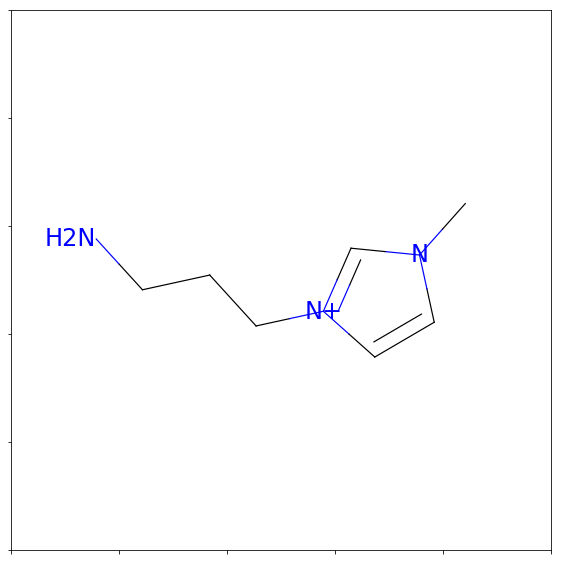

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw
m = Chem.MolFromSmiles("NCCC[n+]1cc[n](c1)C")
a = Draw.MolToMPL(m)

In [ ]:
pd.DataFrame.to_csv(new_df, path_or_buf='../salty/data/density_premodel.csv', index=False)

<a id='optimize'></a>

# Optimize LASSO (alpha hyperparameter)

[back to top](#top)

**I like to shrink my feature space before feeding it into a neural network. **

This is useful for two reasons. We can combat overfitting in our neural network and we can speed up our genetic search algorithm by reducing the number of computations needed in our fitness test--more on this later.

Scikit-learn has a random search algorithm that is pretty easy to implement and useful. I've personally used bootstrap, cross validation, and shuffle-split to parameterize LASSO on ILThermo data and they all agree pretty well with each other. 

In [ ]:
property_model = "density"
df = pd.DataFrame.from_csv('../salty/data/%s_premodel.csv' % property_model, index_col=None)
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
property_scale = dataDf["Specific density, kg/m<SUP>3</SUP>"].apply(lambda x: log(float(x)))
cols = dataDf.columns.tolist()
instance = StandardScaler()
data = pd.DataFrame(instance.fit_transform(dataDf.iloc[:,:-1]), columns=cols[:-1])
df = pd.concat([data, property_scale, metaDf], axis=1)
mean_std_of_coeffs = pd.DataFrame([instance.mean_,instance.scale_], columns=cols[:-1])
viscosity_devmodel = dev_model(mean_std_of_coeffs, df)
pickle_out = open("../salty/data/%s_devmodel.pkl" % property_model, "wb")
pickle.dump(viscosity_devmodel, pickle_out)
pickle_out.close()

**At this point I introduce a new class of objects called devmodel. **

devmodel is a pickle-able object. self.Data contains the scaled/centered feature data and log of the property data as well as the original IUPAC names and SMILES. This makes it easy to consistently unpickle the devmodel and begin using it in an sklearn algorithm without making changes to the dataframe. Self.Coef_data contains the mean and standard deviation of the features so that structure candidates in our genetic algorithm can be scaled and centered appropriately.

In [ ]:
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
df = devmodel.Data
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
X_train = dataDf.values[:,:-1]
Y_train = dataDf.values[:,-1]
#metaDf["Specific density, kg/m<SUP>3</SUP>"].str.split().apply(lambda x: log(float(x[0])))

And now we can parameterize our LASSO model:

In [ ]:
#param_grid = {"alpha": sp_rand(0,0.1), "hidden_layer_sizes" : [randint(10)]}
# model = MLPRegressor(max_iter=10000,tol=1e-8)
param_grid = {"alpha": sp_rand(0.001,0.1)}
model = Lasso(max_iter=1e5,tol=1e-8)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1,\
                         n_iter=15)
grid_result = grid.fit(X_train, Y_train)
print(grid_result.best_estimator_)

<a id='ci_coeff'></a>

# Determine Confidence Intervals for LASSO Coefficients

[back to top](#top)

It can be incredibly useful to look at our coefficient response to changes in the underlying training data (e.g. does it look like one of our features are being selected because of a single type of training datum, category of salt, etc.)

This can be assessed using the bootstrap.

In [ ]:
iterations=2
averages=np.zeros(iterations)
variances=np.zeros(iterations)
test_MSE_array=[]

property_model = "density"
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
df = devmodel.Data
df = df.sample(frac=1)
# df["Viscosity, Pas"] = df["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))
metadf = df.select_dtypes(include=["object"])
datadf = df.select_dtypes(include=[np.number])

          
data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train
deslist=datadf.columns
score=np.zeros(len(datadf.columns))
feature_coefficients=np.zeros((len(datadf.columns),iterations))
test_MSE_array=[]
model_intercept_array=[]
for i in range(iterations):
    data = np.random.permutation(data) 
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))

    ###sample from training set with replacement
    for k in range(n_train):
        x = randint(0,n_train)
        X_train[k] = data[x,:-1]
        Y_train[k] = (float(data[x,-1]))
    n = data.shape[0]
    ###sample from test set with replacement
    for k in range(n_test):
        x = randint(n_train,n)
        X_test[k] = data[x,:-1]
        Y_test[k] = (float(data[x,-1]))

    ###train the lasso model    
    model = Lasso(alpha=0.007115873059701538,tol=1e-10,max_iter=4000)
    model.fit(X_train,Y_train)
    
    ###Check what features are selected
    p=0
    avg_size=[]
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            score[a] = score[a] + 1
            feature_coefficients[a,i] = model.coef_[a] ###append the model coefs 
            p+=1
    avg_size.append(p)
    
    ###Calculate the test set MSE
    Y_hat = model.predict(X_test)
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    test_MSE_array.append(test_MSE)
    
    ###Grab intercepts
    model_intercept_array.append(model.intercept_)
    
print("{}\t{}".format("average feature length:", np.average(avg_size)))
print("{}\t{}".format("average y-intercept:", "%.2f" % np.average(model_intercept_array)))
print("{}\t{}".format("average test MSE:", "%.2E" % np.average(test_MSE_array)))
print("{}\t{}".format("average MSE std dev:", "%.2E" % np.std(test_MSE_array)))
select_score=[]
select_deslist=[]
feature_coefficient_averages=[]
feature_coefficient_variance=[]
feature_coefficients_all=[]
for a in range(len(deslist)):
    if score[a] != 0:
        select_score.append(score[a])
        select_deslist.append(deslist[a])
        feature_coefficient_averages.append(np.average(feature_coefficients[a,:]))
        feature_coefficient_variance.append(np.std(feature_coefficients[a,:]))
        feature_coefficients_all.append(feature_coefficients[a,:])

Executing the following cell will overwrite saved files that were done for many bootstrap itterations.

In [ ]:
#save the selected feature coeffs and their scores
df = pd.DataFrame(select_score, select_deslist)
df.to_pickle("../salty/data/bootstrap_list_scores.pkl")

#save the selected feature coefficients
df = pd.DataFrame(data=np.array(feature_coefficients_all).T, columns=select_deslist)
df = df.T.sort_values(by=1, ascending=False)
df.to_pickle("../salty/data/bootstrap_coefficients.pkl")

#save all the bootstrap data to create a box & whiskers plot
df = pd.DataFrame(data=[feature_coefficient_averages,\
                   feature_coefficient_variance], columns=select_deslist)
df = df.T.sort_values(by=1, ascending=False)
df.to_pickle("../salty/data/bootstrap_coefficient_estimates.pkl")

#save the coefficients sorted by their abs() values
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False).iloc[:]
cols = df.T.columns.tolist()
df = pd.read_pickle('../salty/data/bootstrap_coefficient_estimates.pkl')
df = df.loc[cols]
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
newdf.to_pickle('../salty/data/bootstrap_coefficient_estimates_top_sorted.pkl')

df = pd.DataFrame(select_score, select_deslist)
df.sort_values(by=0, ascending=False)

In [ ]:
model = pd.read_pickle('../salty/data/bootstrap_coefficient_estimates_top_sorted.pkl')
model2 = model.abs()
df = model2.T.sort_values(by=0, ascending=False).iloc[:]
cols = df.T.columns.tolist()
df = pd.read_pickle('../salty/data/bootstrap_coefficients.pkl')
df = df.loc[cols]
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
newdf = newdf.replace(0, np.nan)
props = dict(boxes=tableau20[0], whiskers=tableau20[8], medians=tableau20[4],\
             caps=tableau20[6])
newdf.abs().plot(kind='box', figsize=(5,12), subplots=False, fontsize=18,\
        showmeans=True, logy=False, sharey=True, sharex=True, whis='range', showfliers=False,\
        color=props,  vert=False)
plt.xticks(np.arange(0,0.1,0.02))
print(df.shape)
# plt.savefig(filename='paper_images/Box_Plot_All_Salts.eps', bbox_inches='tight', format='eps',\
#            transparent=True)   

It can also be useful to evaluate the t-scores for the coefficients.

In [ ]:
df = pd.read_pickle('../salty/data/bootstrap_coefficients.pkl')
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
df = newdf
for index, string in enumerate(newdf.columns):
    print(string)
    
    #get mean, std, N, and SEM from our sample
    samplemean=np.mean(df[string])
    print('sample mean', samplemean)
    samplestd=np.std(df[string],ddof=1)
    print('sample std', samplestd)
    sampleN=1000
    samplesem=stats.sem(df[string])
    print('sample SEM', samplesem)

    #t, the significance level of our sample mean is defined as
    #samplemean - 0 / standard error of sample mean
    #in other words, the number of standard deviations
    #the coefficient value is from 0
    #the t value by itself does not tell us very much
    t=(samplemean)/samplesem
    print('t', t)

    #the p-value tells us the propbability of achieving a value
    #at least as extreme as the one for our dataset if the null
    #hypothesis were true
    p=stats.t.sf(np.abs(t),sampleN-1)*2 #multiply by two for two-sided test
    print('p', p)

    #test rejection of the null hypothesis based on 
    #significance level of 0.05
    alpha=0.05
    if p < alpha:
        print('reject null hypothesis')
    else:
        print('null hypothesis accepted')

# Create Models Progressively Dropping Features

[back to top](#top)

A last check that I find very useful is progressively dropping features from the LASSO model (based on their average coefficients--see box and whiskers plot above). At some point we should see that the inclusion of additional features doesn't improve the performance of the model. In this case we see improvement fall off at about 15-20 features.

In [ ]:
mse_scores=[]
for i in range(df.shape[0]):
    model = pd.read_pickle('../salty/data/bootstrap_coefficient_estimates_top_sorted.pkl')
    model2 = model.abs()
    df = model2.T.sort_values(by=0, ascending=False).iloc[:i]
    cols = df.T.columns.tolist()
    model = model[cols]
    cols = model.columns.tolist()
    cols.append("Specific density, kg/m<SUP>3</SUP>")
    
    property_model = "density"
    pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
    devmodel = pickle.load(pickle_in)
    df = devmodel.Data
    df = df.sample(frac=1)
    metadf = df.select_dtypes(include=["object"])
    datadf = df.select_dtypes(include=[np.number])
    df = datadf.T.loc[cols]
    data=np.array(df.T)

    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = 0#int(n*0.8) #set fraction of data to be for training
    n_test  = n - n_train

    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = (data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = (data[n_train:,-1].astype(float))
    Y_hat = np.dot(X_test, model.loc[0])+np.mean(Y_test[:] - np.dot(X_test[:], model.loc[0]))
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    mse_scores.append(test_MSE) 

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(mse_scores)
    ax.grid(False)
# plt.xticks(np.arange(0,31,10))
# plt.yticks(np.arange(0,1.7,.4))

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

I set avg_selected_features to the number of features I want to include based on the box-whiskers plot, t-tests, and progressively dropped features model. I've set this value to 20 in the cell bellow.

In [ ]:
####Create dataset according to LASSO selected features
df = pd.read_pickle("../salty/data/bootstrap_list_scores.pkl")
df = df.sort_values(by=0, ascending=False)
avg_selected_features=20
df = df.iloc[:avg_selected_features]

#coeffs = mean_std_of_coeffs[cols]
property_model = "density"
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
rawdf = devmodel.Data
rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])
to_add=[]
for i in range(len(df)):
    to_add.append(df.index[i])
cols = [col for col in datadf.columns if col in to_add]
cols.append("Specific density, kg/m<SUP>3</SUP>")
df = datadf.T.loc[cols]

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

In [ ]:
# Load the Python scripts that contain the Bayesian optimization code
%run gp.py
# %run plotters.py
def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

I usually optimize my MLP regressor hyper parameters with any new type of dataset. This takes a long time to run so I use the Hyak supercomputer.

In [ ]:
###Randomized Search NN Characterization
param_grid = {"activation": ["identity", "logistic", "tanh", "relu"],\
             "solver": ["lbfgs", "sgd", "adam"], "alpha": sp_rand(),\
             "learning_rate" :["constant", "invscaling", "adaptive"],\
             "hidden_layer_sizes": [randint(100)]}

model = MLPRegressor(max_iter=400,tol=1e-8)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,\
                          n_jobs=-1, n_iter=10)
grid_result = grid.fit(X_train, Y_train)

print(grid_result.best_estimator_)

In [ ]:
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
model.fit(X_train,Y_train)

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(np.exp(Y_test),np.exp(model.predict(X_test)),\
            marker=".",linestyle="")

<a id='static'></a>

# Save the final model to be used in the [GAINS](https://github.com/wesleybeckner/gains) fitness test

[back to top](#top)

In [ ]:
prodmodel = prod_model(coeffs, model)
pickle_out = open("../salty/data/%s_prodmodel.pkl" % property_model, "wb")
pickle.dump(prodmodel, pickle_out)
pickle_out.close()